# 1D Wavelength Calibration Tutorial 1: Interactive Workflow

This notebook demonstrates a basic interactive workflow for wavelength calibration of
astronomical spectra using the `WavelengthSolution1D` class with a single
calibration lamp (arc) spectrum. It serves as a general introduction to the class.

The interactive workflow consists of these key steps:
1. Loading the arc spectrum data
2. Initializing the wavelength solution parameters
3. Finding emission line positions in the spectrum 
4. Inspecting catalog line wavelengths
5. Manually identifying initial line matches
6. Evaluating and refining the wavelength solution
7. Applying the solution to calibrate spectra

This example uses a [He-Hg-Cd lamp arc](https://mthamilton.ucolick.org/techdocs/instruments/kast/images/Kastblue600HeHgCd.jpg) from the [Shane telescope's](https://www.lickobservatory.org/explore/research-telescopes/shane-telescope/) [Kast spectrograph](https://mthamilton.ucolick.org/techdocs/instruments/kast/index.html).

In [ ]:
import astropy.units as u
import numpy as np

from astropy.io.fits import getdata
from astropy.nddata import StdDevUncertainty
from matplotlib.pyplot import setp, subplots, close, rc

from specreduce.compat import Spectrum
from specreduce.wavecal1d import WavelengthCalibration1D

rc('figure', figsize=(11, 3))

## 1. Read in the Arc Spectrum

First, we load the arc lamp flux data and create a `specutils.Spectrum` object, assuming that the flux is measured in counts (digital number units, `u.DN`). We also include measurement uncertainties. While these uncertainties are not directly used in fitting the wavelength solution, they are required by the default line-finding routine (`specutils.fitting.find_lines_threshold`).


In [3]:
flux = getdata('shane_kast_blue_600_4310_d55.fits', 1).astype('d')
arc_spectrum = Spectrum((flux - np.median(flux)) * u.DN, uncertainty=StdDevUncertainty(np.sqrt(flux)))

## 2. Initialize the Wavelength Solution Class

Now we instantiate the `WavelengthSolution1D` class. This class manages the input data, fitted model, and provides methods for solution fitting and spectrum calibration.

Key initialization parameters:

- `ref_pixel`: Reference pixel coordinate near detector center. The polynomial fit centers around this pixel to improve numerical stability.
- `degree`: Degree of the `astropy.modeling.polynomial.Polynomial1D` model for pixel-to-wavelength mapping. Higher degrees enable more complex curves but require more lines for stability and risk overfitting.
- `line_lists`: Either lamp names (e.g., 'HeI', 'NeI', 'ArI') recognized by `specreduce.calibration_data.load_pypeit_calibration_lines`, or NumPy arrays of theoretical line wavelengths. Here we provide lamp names for our single spectrum.
- `arc_spectra`: Observed arc spectra as `specutils.Spectrum` objects, used for automatic line finding if `obs_lines` is not provided.
- `obs_lines`: Pre-identified line pixel centroids. If provided, `arc_spectra` is not needed for line finding.
- `pix_bounds`: Detector pixel range `(min_pix, max_pix)`. Inferred from `arc_spectra` if provided; required with `obs_lines`.
- `line_list_bounds`: Wavelength range `(min_wav, max_wav)` for filtering `line_lists`. Defaults to `(0, +inf)`.
- `wave_air`: If `True`, converts PyPEIT's vacuum wavelengths to air wavelengths.

In this example, we provide:
- Arc spectrum
- Reference pixel at 1000 
- Polynomial degree 5
- Lamp list `['CdI', 'HgI', 'HeI']`
- Wavelength filter range 3200-5700 Angstroms

The `plot_observed_lines` method displays the arc spectra and input lines in pixel space. At this stage, it shows only the raw input spectrum since no lines have been identified or fitted.


In [ ]:
ws = WavelengthCalibration1D(ref_pixel=1000, degree=5, arc_spectra=arc_spectrum, line_lists=[['CdI', 'HgI', 'HeI']],
                             line_list_bounds=(3200, 5700), unit=u.angstrom)
ws.plot_observed_lines();

## 3. Find Line Pixel Positions

Next, we detect emission lines in the arc spectrum using the `find_lines` method. This method uses `specreduce.line_matching.find_arc_lines`, which performs peak detection to identify lines and calculate their centroids (in pixel coordinates). The detected line centroids are stored in the `ws.observed_lines` attribute as a list of NumPy masked arrays (one array per input arc spectrum). Initially, none of the lines are masked.

The plot now overlays vertical lines at the pixel coordinates of the found lines.

**Note:** If we had already identified the line centroids by other means (e.g., manually, or from another program), we could have supplied them directly during initialization using the `obs_lines` argument, skipping this step.

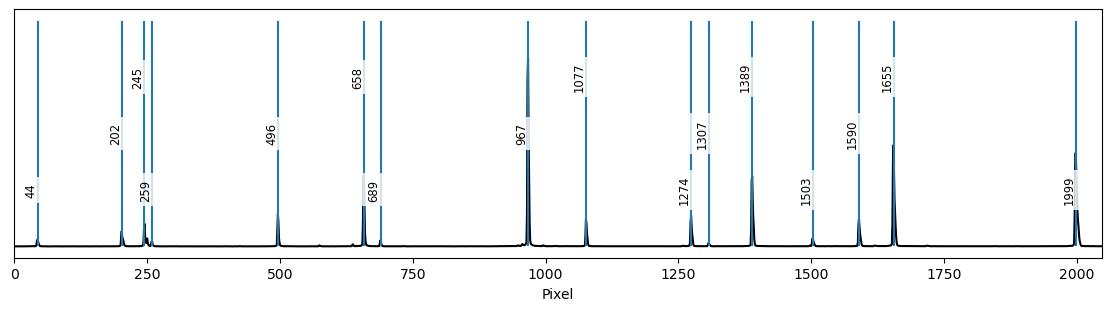

In [11]:
ws.find_lines(fwhm=4, noise_factor=15)
ws.plot_observed_lines();

## 4. Inspect the Catalog Line List

When we initialized `WavelengthSolution1D`, we provided lamp names (`line_lists=[['CdI', 'HgI', 'HeI']]`). Internally, the `_read_linelists` method loaded the corresponding known wavelengths (filtered by `line_list_bounds`), converted them to the specified `unit` (Angstroms by default), and stored them in the `ws.catalog_lines` attribute.

Like `observed_lines`, `catalog_lines` is a list of masked arrays (one per arc spectrum), sorted by wavelength. We can visualize these theoretical line positions using `plot_catalog_lines`.

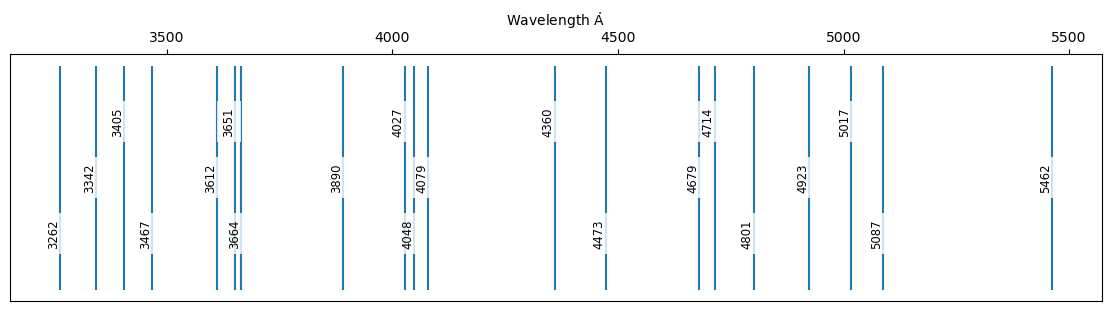

In [14]:
ws.plot_catalog_lines();

We can use the `plot_fit` method to visualize both the observed lines (bottom panel, pixel space) and the catalog lines (top panel, wavelength space) simultaneously. 

Since we haven't yet calculated a pixel-to-wavelength transformation, the bottom panel is plotted in pixel coordinates and we should not expect any matches between the observed and catalog lines.

In [6]:
from astropy.modeling.models import Polynomial1D
from specreduce.wavecal1d import _diff_poly1d

In [9]:
p = Polynomial1D(3, c0=1, c1=2, c2=3, c3=4)
_diff_poly1d(p).parameters

array([ 2.,  6., 12.])

In [8]:
p.parameters

array([1., 2., 3., 4.])

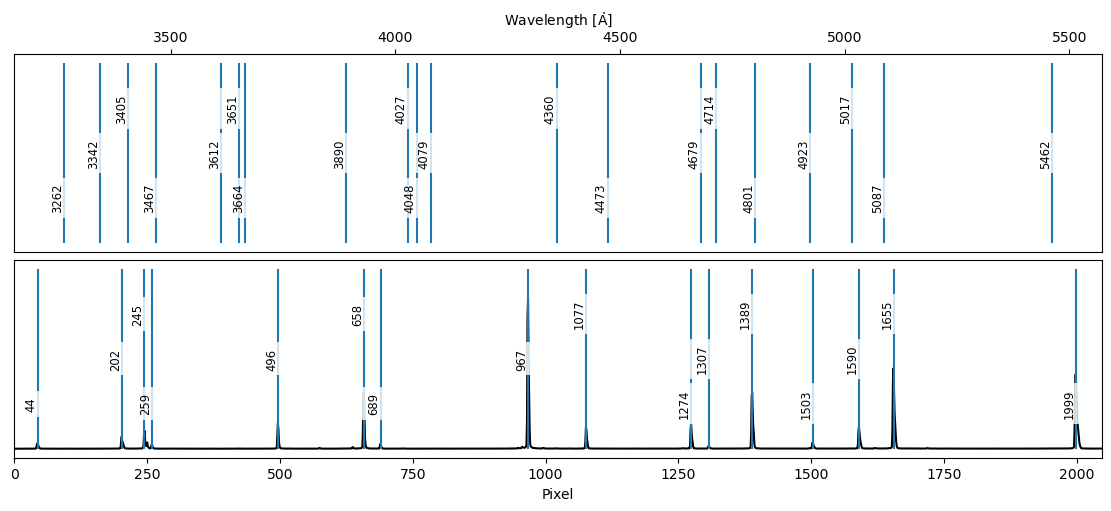

In [15]:
ws.plot_fit(figsize=(11,5), plot_values=True);

## 5. Fit an Initial Solution Manually

To establish an initial relationship between pixels and wavelengths, we need to match some observed lines to their corresponding catalog wavelengths. 

The `WavelengthSolution1D` class offers several ways to fit:
1. `fit_lines(pixels, wavelengths)`: Fits the model using explicitly provided pairs of corresponding pixel and wavelength values. This is useful for manual identification of a few bright, unambiguous lines to get a starting solution.
2. `fit_global()`: Performs a global optimization to find an initial model by minimizing distances between transformed observed lines and the KDTrees of theoretical lines. This requires good initial guesses for wavelength and dispersion bounds but is more suitable for an automatic pipeline.
3. `refine_fit()`: Improves an existing fit by automatically matching lines based on the current solution and performing a least-squares fit on the matches. This method is called by the `fit_lines` and `fit_global` methods by default, but can also be called manually.

In this example, we'll use `fit_lines` with a few manually identified pairs. We visually inspect the plots above (or use an interactive tool in a real scenario) to find approximate correspondences. We also set `match_pix` and `match_wav` to `True` to match the approximate pixel and wavelength line values with the more accurate observed line centroids and catalog wavelength values.

In [16]:
ws.fit_lines(pixels=[496, 967, 1077, 1655, 1999], wavelengths=[3890, 4360, 4473, 5087, 5462], match_obs=True, match_cat=True)

 [astropy.modeling.fitting]


Now, we can plot the solution mapping the observed pixel values to wavelengths (`obs_to_wav=True`). The plot shows matching observed and catalog lines as solid blue vertical lines, while unmatched lines are shown as dotted lines.  

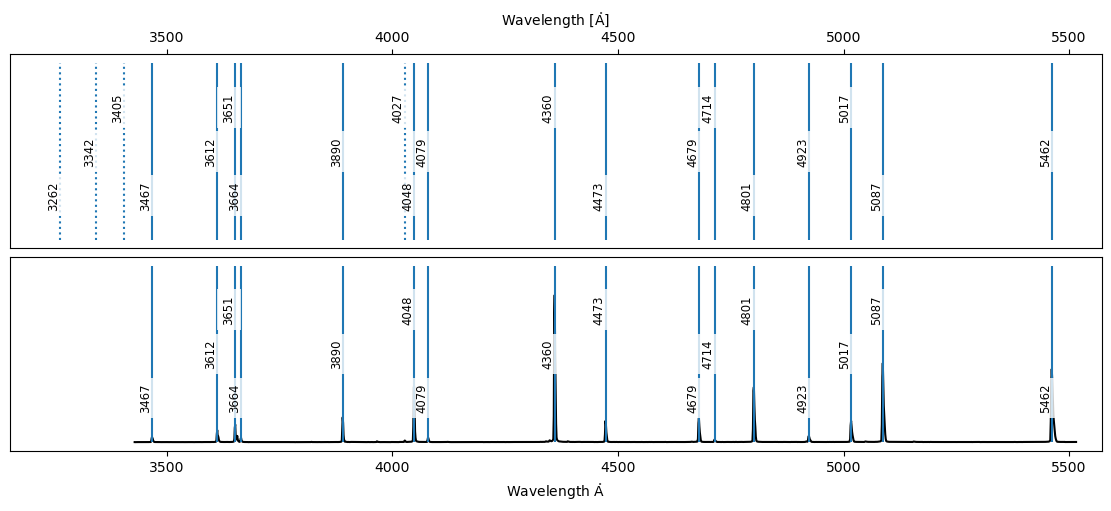

In [17]:
ws.plot_fit(figsize=(11,5), plot_values=True, obs_to_wav=True);

## 6. Evaluate the Initial Fit: Plot Residuals

Let's check the quality of this initial fit. The `plot_residuals` method calculates the difference between the theoretical wavelength of matched lines and the wavelength predicted by the current model for their observed pixel positions. The RMS estimate alone can be calculated using the `rms` method.

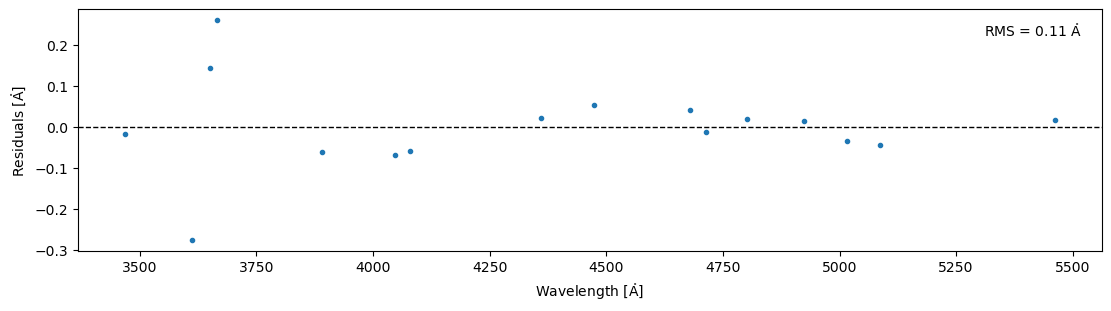

In [31]:
ws.plot_residuals(space='wavelength');

The fit looks good! Now, we can move on to use the solution.

### 7. Use the solution
#### 7.1 Rebin a Spectrum to Wavelength Space

A primary goal of wavelength calibration is to transform spectra from the detector's pixel grid to a physical wavelength grid. The `resample` method does this, converting a `Spectrum` object from pixel space to wavelength space.

Key parameters for `resample`:
- `spectrum`: The input `Spectrum` object (assumed to be on a pixel grid corresponding to the calibration).
- `nbins`: The number of bins desired in the output wavelength grid. If `None`, defaults to the number of pixels in the input spectrum.
- `wlbounds`: The desired `(start_wavelength, end_wavelength)` for the output grid. If `None`, defaults to the wavelengths corresponding to the first and last pixels.
- `bin_edges`: Explicitly define the wavelength edges of the output bins. If provided, `nbins` and `wlbounds` are ignored.

The method uses the fitted `_p2w`, `_w2p`, and `_p2w_dldx` transformations to map the input pixel bins to the output wavelength bins. It performs an exact flux-conserving rebinning, meaning the total flux in the output spectrum matches the total flux in the input spectrum (adjusted for the units transformation from counts/pixel to counts/wavelength_bin).

Here, we demonstrate by resampling the original arc spectrum itself. In a typical workflow, you would apply this `resample` method (using the `ws` object derived from the arc lamp) to your *science* spectrum observed with the same instrument setup.

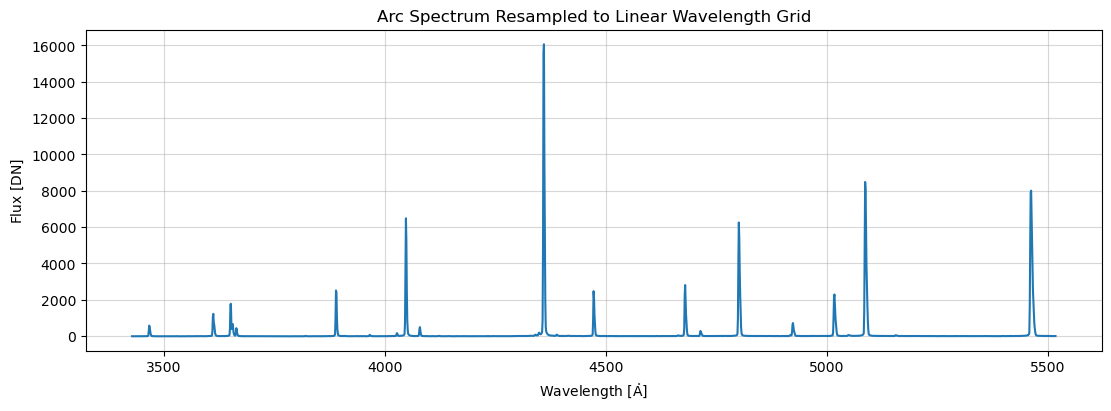

In [21]:
spectrum_wl = ws.resample(arc_spectrum)

fig, ax = subplots(constrained_layout=True, figsize=(11, 4))
ax.plot(spectrum_wl.spectral_axis, spectrum_wl.flux)
ax.set_xlabel(f"Wavelength [{spectrum_wl.spectral_axis.unit.to_string('latex')}]")
ax.set_ylabel(f"Flux [{spectrum_wl.flux.unit.to_string('latex')}]")
ax.set_title("Arc Spectrum Resampled to Linear Wavelength Grid")
ax.grid(True, alpha=0.5)

Let's still check that the flux is indeed conserved as it should

In [25]:
spectrum_wl.flux.sum()

<Quantity 244192.08708692 DN>

In [26]:
arc_spectrum.flux.sum()

<Quantity 244192.08708692 DN>

#### 7.2 access the WCS

Additionally, if we don't want to rebin, or maybe want to do it using another method, we can access the pixel-wavelength transform as a [gwcs](https://gwcs.readthedocs.io/) WCS object usin the `WCS` property.

In [157]:
ws.wcs.pixel_to_world(0)

<SpectralCoord 3428.33945405 Angstrom>

## Summary

The interactive workflow (in the sense that it requires user input for the initial line fit) for 1D wavelength calibration can be summarized as follows:

In [ ]:
ws = WavelengthCalibration1D(ref_pixel=1000, degree=5, arc_spectra=arc_spectrum, line_lists=[['CdI', 'HgI', 'HeI']], line_list_bounds=(3200, 5700), unit=u.angstrom)
ws.find_lines(fwhm=4, noise_factor=15)
ws.fit_lines(pixels=[496, 967, 1077, 1655, 1999], wavelengths=[3890, 4360, 4473, 5087, 5462], match_obs=True, match_cat=True)
ws.plot_fit(figsize=(11,5), plot_values=True, obs_to_wav=True);

---